In [1276]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import DataFrame
import random
import time

plt.rcParams["figure.figsize"] = (20, 10)

Function: $y = \frac{exp(-1*x)}{2+3*x}$

In [1277]:
func = lambda x, b1, b2, b3: np.e ** (-b1 * x) / (b2 + b3 * x)
minimizing_func = lambda b: np.sum((func(xs, b[0], b[1], b[2]) - ys) ** 2)

const_lr = lambda n, start: start
exp_lr = lambda n, start: start * np.exp(-0.01 * n)

In [1278]:
start_point = [2, 4, 5]

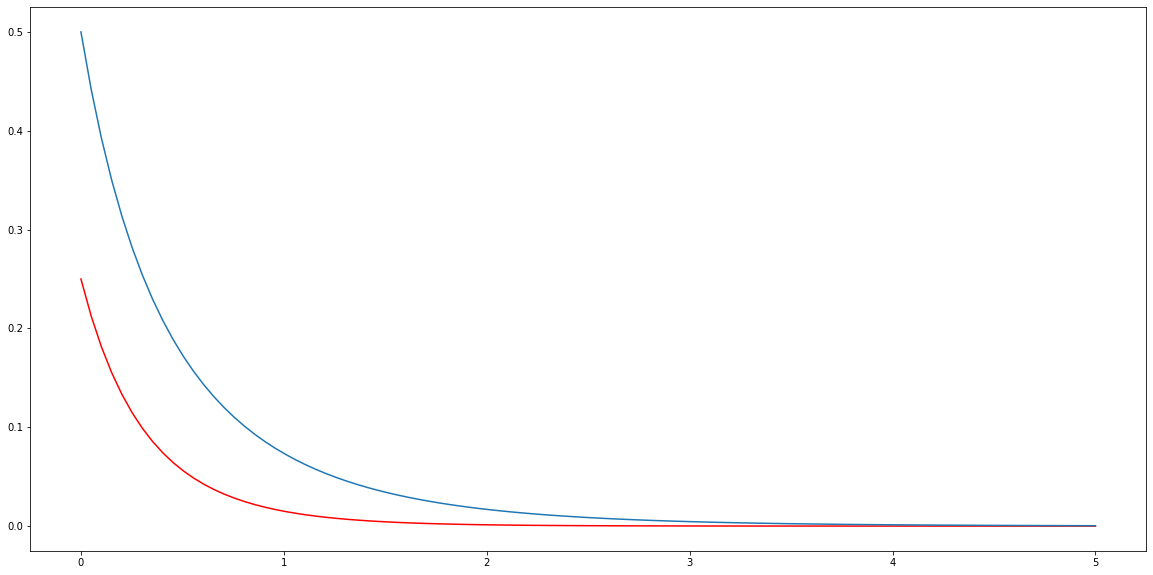

In [1279]:
exp_beta_1 = 1
exp_beta_2 = 2
exp_beta_3 = 3

xs = np.linspace(0, 5, 100)
ys = func(xs, exp_beta_1, exp_beta_2, exp_beta_3)

plt.plot(xs, func(xs, *start_point), '-r')
plt.plot(xs, ys)

In [1280]:
def partial(f, i, x):
    h = 1e-5
    x[i] = x[i] + h
    right = f(x)
    x[i] = x[i] - 2 * h
    left = f(x)
    x[i] = x[i] + h

    return (right - left) / (2 * h)


def grad(f, x):
    return [partial(f, i, x) for i in range(len(x))]


def minibatch_grad(func, x, batch):
    return grad(func, x)


def cancel_condition(x):
    return np.linalg.norm(grad(minimizing_func, x)) < 1e-6


def adam(f, b1, b2, lr, start, lr_strategy=exp_lr, epoch=20, batch=1):
    x = start
    prev_grad = np.array([0, 0, 0])
    prev_v = np.array([0, 0, 0])
    points = list()
    grads = list()
    loss1 = list()
    points.append(start)
    for i in range(1, epoch):
        gr = np.array(minibatch_grad(f, x, batch))
        grads.append(np.linalg.norm(gr))
        loss1.append(f(x))
        g = b1 * prev_grad + (1 - b1) * gr
        v = b2 * prev_v + (1 - b2) * np.power(gr, 2)
        x = x - lr_strategy(i, lr) * g / np.sqrt(v)
        prev_v = v
        prev_grad = g
        points.append(x)
        if cancel_condition(x):
            break

    return [np.array(points), np.array(grads), np.array(loss1)]

Итераций:  627


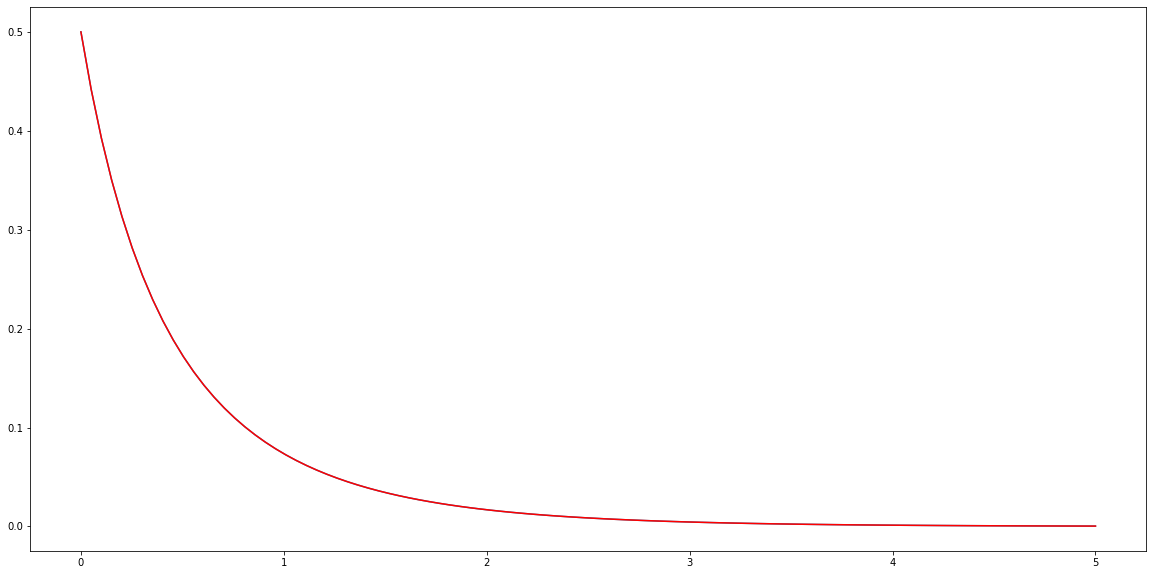

In [1281]:
points, grads1, loss1 = adam(minimizing_func, b1=0.5, b2=0.5, lr=0.2, start=start_point, lr_strategy=exp_lr,
                             epoch=50000,
                             batch=30)

ans = points[-1]

plt.plot(xs, func(xs, ans[0], ans[1], ans[2]))

plt.plot(xs, ys, 'r')

print("Итераций: ", len(points))

In [1282]:
def minibatch_sgd(f, lr, start, lr_strategy=exp_lr, epoch=20, batch=1):
    x = start

    points = list()
    grads = list()
    loss = list()
    points.append(x)
    for i in range(1, epoch):
        grads.append(np.linalg.norm(minibatch_grad(f, x, batch)))
        loss.append(f(x))
        x = x - lr_strategy(i, lr) * np.array(minibatch_grad(f, x, batch))
        points.append(x)
        if cancel_condition(x):
            break

    return [np.array(points), np.array(grads), np.array(loss)]


def gd(f, lr, start, lr_strategy=const_lr, epoch=20):
    return minibatch_sgd(f, lr, start, lr_strategy=lr_strategy, epoch=epoch, batch=30)

Итераций 18613


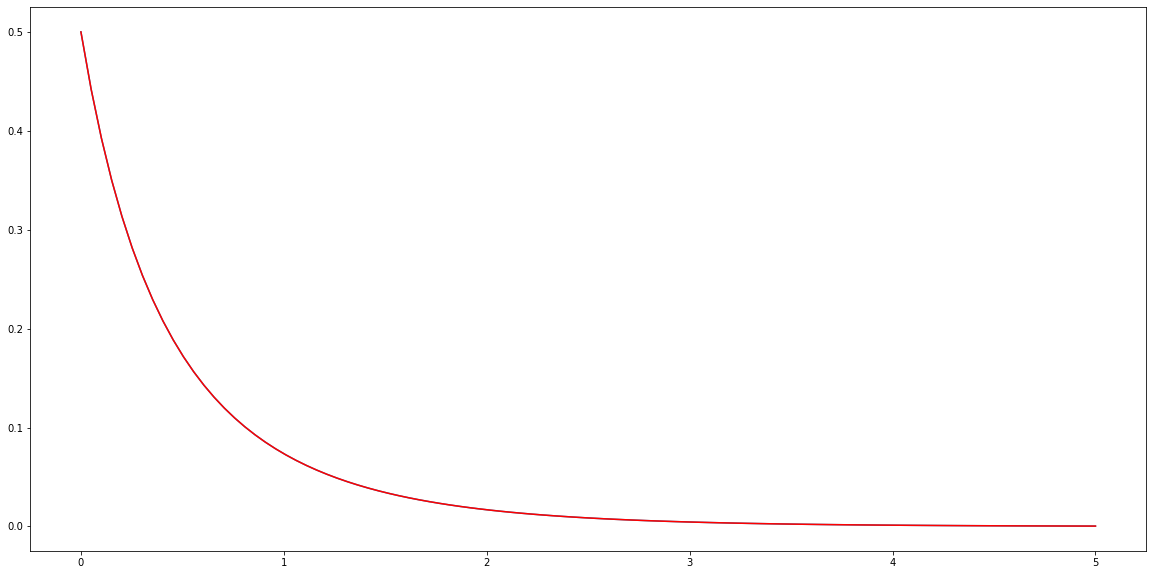

In [1283]:
points, grads3, loss3 = gd(minimizing_func, 0.3, start=start_point, lr_strategy=const_lr, epoch=50000)

print("Итераций", len(points))

ans = points[-1]
plt.plot(xs, func(xs, ans[0], ans[1], ans[2]), '-')

plt.plot(xs, ys, 'r')



------------------------------------------------------------------

In [1284]:
def cancel_condition2(x):
    return np.linalg.norm(grad(minimizing_func, x)) < 1e-6


def minimizing_func2(b, idxs=range(100)):
    res = 0
    for i in idxs:
        res += (func(xs[i], b[0], b[1], b[2]) - ys[i]) ** 2
    return res

In [1285]:
def partial2(f, i, x, idxs):
    h = 1e-5
    x[i] = x[i] + h
    right = f(x, idxs)
    x[i] = x[i] - 2 * h
    left = f(x, idxs)
    x[i] = x[i] + h

    return (right - left) / (2 * h)


def grad2(f, x, idx_of_term, idx_of_var):
    return partial2(f, idx_of_var, x, idx_of_term)

In [1286]:
# p = -(J^T * J)^(-1) J * r

def calcP(x):
    res = list()
    for i in range(3):
        row = list()
        for j in range(100):
            row.append(grad2(minimizing_func2, x, [j], i))
        res.append(row)
    JT = np.array(res)
    hh = -np.linalg.inv(JT @ JT.transpose()) @ JT
    rs = list()
    for i in range(100):
        rs.append(minimizing_func2(x, [i]))
    res = hh @ np.array(rs).transpose()
    return res


def newton(f, lr, start, lr_strategy=const_lr, epoch=20):
    x = start
    points = list()
    grads = list()
    loss2 = list()
    points.append(start)
    for i in range(1, epoch):
        loss2.append(f(x))
        grads.append(np.linalg.norm(grad(minimizing_func, x)))
        x = x + lr_strategy(i, lr) * np.array(calcP(x))
        points.append(x)
        if cancel_condition2(x):
            break

    return [np.array(points), grads, loss2]

Итераций 23


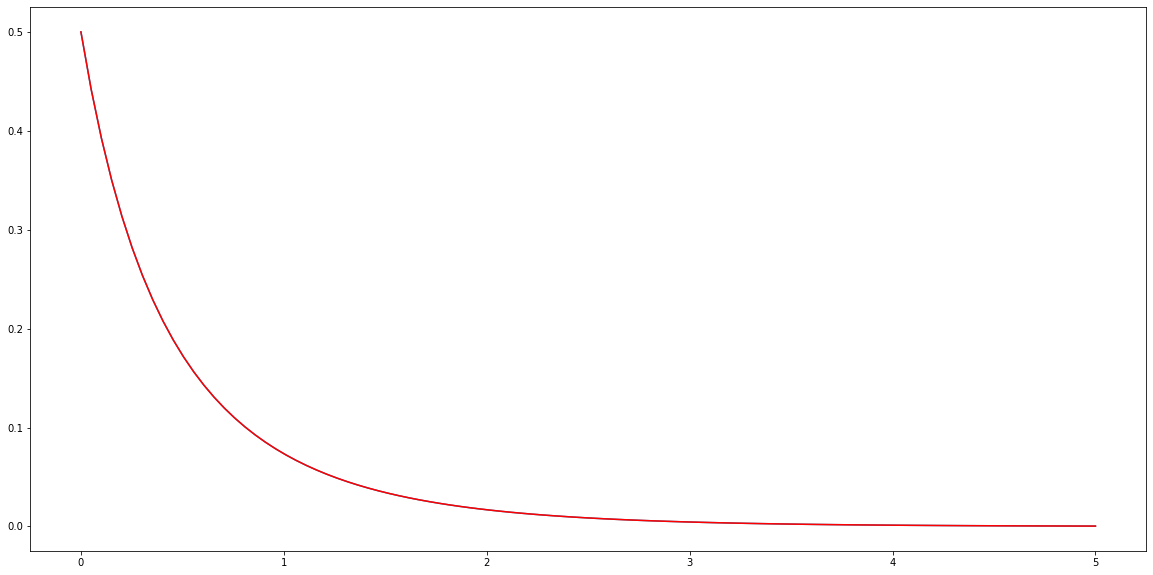

In [1287]:
points, grads2, loss2 = newton(minimizing_func2, 1, start=start_point, lr_strategy=exp_lr, epoch=2000)

print("Итераций", len(points))

ans = points[-1]
plt.plot(xs, func(xs, ans[0], ans[1], ans[2]), '-')

plt.plot(xs, ys, 'r')

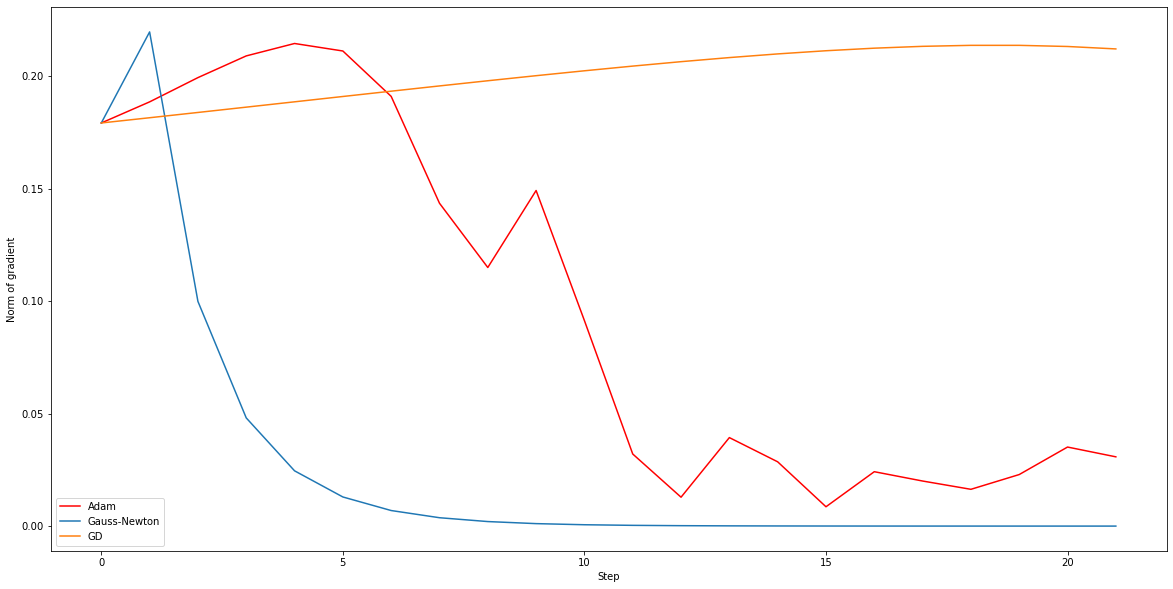

In [1288]:
ss = range(0, len(points) - 1)

plt.plot(ss, grads1[:len(points) - 1], 'r', label='Adam')
plt.plot(ss, grads2[:len(points) - 1], label='Gauss-Newton')
plt.plot(ss, grads3[:len(points) - 1], label='GD')

plt.xlabel("Step")
plt.ylabel("Norm of gradient")

plt.legend()

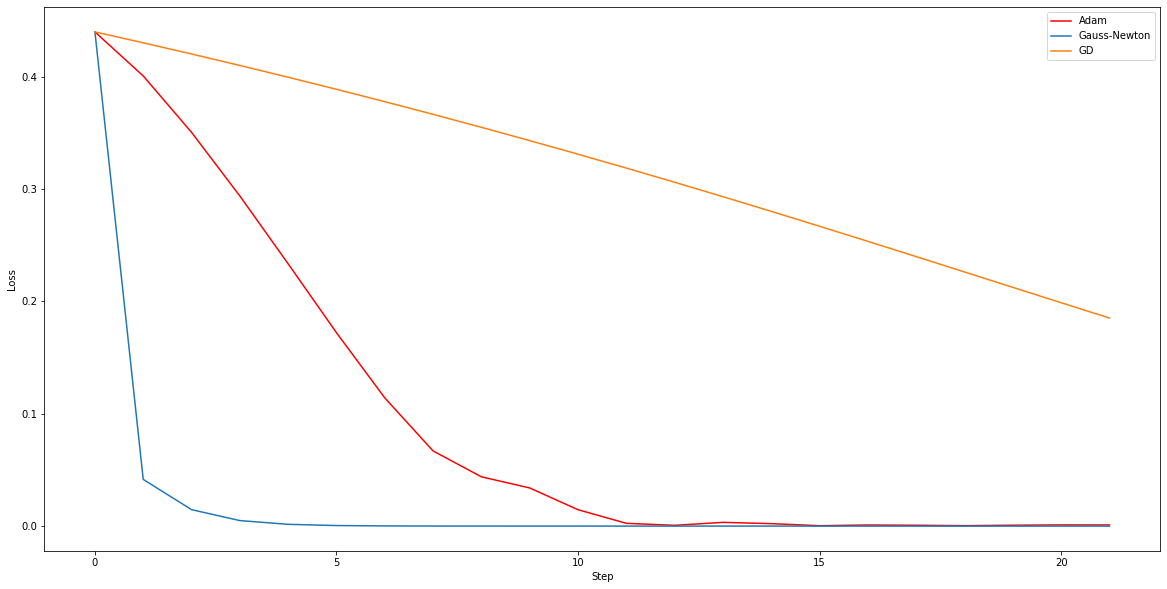

In [1289]:
ss = range(0, len(points) - 1)

plt.plot(ss, loss1[:len(points) - 1], 'r', label='Adam')
plt.plot(ss, loss2[:len(points) - 1], label='Gauss-Newton')
plt.plot(ss, loss3[:len(points) - 1], label='GD')

plt.xlabel("Step")
plt.ylabel("Loss")

plt.legend()

## DOGLEG

In [1290]:
def partial3(f, i, x):
    h = 1e-5
    x[i] = x[i] + h
    right = f(x)
    x[i] = x[i] - 2 * h
    left = f(x)
    x[i] = x[i] + h

    return (right - left) / (2 * h)


def grad3(f, x):
    return [partial(f, i, x) for i in range(len(x))]

def cancel_condition(x):
    return np.linalg.norm(grad3(minimizing_func, x)) < 1e-6


def getRo(f, x, p):
    fx = f(x) - f(x + p)
    mk = m(f, x, np.array([0, 0, 0])) - m(f, x, p)
    return fx / mk


def grad(x):
    res = list()
    for i in range(3):
        row = list()
        for j in range(100):
            row.append(grad2(minimizing_func2, x, [j], i))
        res.append(row)
    JT = np.array(res)
    rs = list()
    for i in range(100):
        rs.append(minimizing_func2(x, [i]))
    return 2 * JT @ np.array(rs).transpose()


def m(f, x, p):
    print(np.transpose(grad(x)))
    print(p)

    first = np.transpose(grad(x)) @ p
    second = np.transpose(p) @ calcH(x) @ p
    return f(x) + first + 1 / 2 * second


def calcH(x):
    res = list()
    for i in range(3):
        row = list()
        for j in range(100):
            row.append(grad2(minimizing_func2, x, [j], i))
        res.append(row)
    JT = np.array(res)
    res = JT @ np.transpose(JT)
    return 2 * res


def calcStep(f, x, delta):
    H = calcH(x)
    gr = grad(x)

    pH = -np.linalg.inv(H) @ gr

    if np.linalg.norm(pH) <= delta:
        return pH

    # print(gr)
    pU = - (np.dot(gr, gr) / np.dot(gr, np.dot(H, gr))) * gr

    # first = np.transpose(gr) @ gr
    # second = np.transpose(gr) @ H @ gr

    # print(first)
    # print(second)

    # third = -(first) / (second)
    # print(third)
    # print(gr)
    # pU = third @ gr



    if np.linalg.norm(pU) >= delta:
        return delta * pU / np.linalg.norm(pU)


    A = pU
    B = pH - pU

    D4 = (np.transpose(A) @ B) @ (np.transpose(A) @ B) - (np.transpose(B) @ B) @ (np.transpose(A) @ A - delta * delta)

    return (-np.transpose(A) @ B + np.sqrt(D4)) / (np.transpose(B) @ B)


def dogleg(f, start, delta=1, nu=1 / 4, epoch=20, delta_max=100):
    x = start

    points = list()

    grads = list()
    loss = list()

    points.append(start)

    for i in range(1, epoch):

        p = calcStep(f, x, delta)
        # print(p)
        ro = getRo(f, x, p)

        if ro < 1 / 4:
            delta = 1 / 4 * delta
        elif ro > 3 / 4 and np.linalg.norm(ro) == delta:
            delta = min(2 * delta, delta_max)
        else:
            delta = delta

        if ro > nu:
            x = x + p
        else:
            x = x

        points.append(x)

        if cancel_condition(x):
            break

    return [np.array(points), np.array(grads), np.array(loss1)]

In [1291]:
points, grads, loss = dogleg(minimizing_func, start_point, delta=1, epoch=1000)

[0.00513833 0.010637   0.00097975]
[0 0 0]
[0.00513833 0.010637   0.00097975]
[-0.43348238 -0.89736355 -0.08265403]
[0.00308163 0.00683087 0.0006971 ]
[0 0 0]
[0.00308163 0.00683087 0.0006971 ]
[-0.40945565 -0.90761607 -0.09262363]
[0.00056056 0.00071731 0.00014407]
[0 0 0]
[0.00056056 0.00071731 0.00014407]
[-0.17767527 -0.1060089  -0.91793996]
[5.33418244e-05 8.05344309e-05 1.56086742e-05]
[0 0 0]
[5.33418244e-05 8.05344309e-05 1.56086742e-05]
[ 3.93533893e-04 -4.60317298e-02 -4.85797896e-01]
[5.79013681e-06 9.53023109e-06 1.81422657e-06]
[0 0 0]
[5.79013681e-06 9.53023109e-06 1.81422657e-06]
[ 0.00823182 -0.0218562  -0.21805878]
[6.76730966e-07 1.16101191e-06 2.19046951e-07]
[0 0 0]
[6.76730966e-07 1.16101191e-06 2.19046951e-07]
[ 0.00557208 -0.01065165 -0.10325162]
[8.18597350e-08 1.43325219e-07 2.69197914e-08]
[0 0 0]
[8.18597350e-08 1.43325219e-07 2.69197914e-08]
[ 0.00310725 -0.0052582  -0.05027068]
[1.00676759e-08 1.78056710e-08 3.33678407e-09]
[0 0 0]
[1.00676759e-08 1.7805671

In [1292]:
points

array([[2.        , 4.        , 5.        ],
       [1.56651762, 3.10263645, 4.91734597],
       [1.15706196, 2.19502038, 4.82472234],
       [0.9793867 , 2.08901148, 3.90678238],
       [0.97978023, 2.04297975, 3.42098448],
       [0.98801205, 2.02112355, 3.2029257 ],
       [0.99358413, 2.0104719 , 3.09967408],
       [0.99669138, 2.00521369, 3.0494034 ],
       [0.99832105, 2.00260131, 3.02459501],
       [0.99915443, 2.00129927, 3.01227104],
       [0.9995757 , 2.00064929, 3.00612893],
       [0.99978747, 2.00032456, 3.00306282],
       [0.99989364, 2.00016226, 3.001531  ],
       [0.9999468 , 2.00008112, 3.0007654 ],
       [0.99997339, 2.00004056, 3.00038267],
       [0.99998669, 2.00002028, 3.00019133],
       [0.99999335, 2.00001014, 3.00009566],
       [0.99999667, 2.00000507, 3.00004783],
       [0.99999834, 2.00000253, 3.00002392],
       [0.99999917, 2.00000127, 3.00001196],
       [0.99999958, 2.00000063, 3.00000598]])